## Maps of ocean surface DMS concentration 
- Global maps of the DMS concentration (mol/m3) at the ocean surface annually averaged for the historical experiment from CNRMESM2-1 and UKESM1-0 for different ensembles
- Green land area of the same thing as above
- Later on, maybe, a contrasting area in Siberia

In [2]:
# load useful packages
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy 
import cartopy.crs as ccrs
import functions
import s3fs
import pandas as pd
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
%matplotlib inline

### open CMIP6 online catalog from pangeo
### Load data from CMIP6 of DMS from ocean for fully coupled model simulations (ocean + atmosphere). Historical experiment.

In [49]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(variable_id=['dmso'],experiment_id=['historical'])
#cat = col.search(variable_id=['emidms'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Omon,dmso,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206


### After what we found on pangeo, we load DMS data from CNRM_ESM2-1 (only one available), historical experiment. 
Note: It would be ideal to find more ensembles to average over them.

In [4]:
cat = col.search(variable_id=['dmso'],source_id=['CNRM-ESM2-1'],
 activity_id = ['CMIP'], experiment_id=['historical'], table_id=['Omon'], 
                  member_id=['r1i1p1f2']
                )
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Omon,dmso,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206


In [5]:
### data from CMIP6 of DMS for OMIP model simulations, where the atmosphere is prescribed. These data are in a bucket and not in pangeo
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
list(dset_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn']

### since our focus is only on the surface DMS concentration and the here dmso is over all levels, we choose only the surface one and ignore the rest.

In [6]:
dset = dset_dict['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn']
dset = dset.isel(lev=0).squeeze()
dset
## checking the metadata
print(dset['dmso'])

<xarray.DataArray 'dmso' (time: 1980, y: 294, x: 362)>
dask.array<getitem, shape=(1980, 294, 362), dtype=float32, chunksize=(4, 294, 362), chunktype=numpy.ndarray>
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lev        float64 0.5058
    lon        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    member_id  <U8 'r1i1p1f2'
Dimensions without coordinates: y, x
Attributes:
    cell_measures:       area: areacello volume: volcello
    cell_methods:        area: mean where sea time: mean
    description:         Mole Concentration of Dimethyl Sulphide in sea water
    history:             none
    interval_operation:  1800 s
    interval_write:      1 month
    long_name:           Mole Concentration of Dimethyl Sulphide in sea water
    online_operation:    average
    standard_name:       mole_concentration_of_dimethyl_sulfide_in_sea_water
    u

### selecting the area using "where" function and plotting it

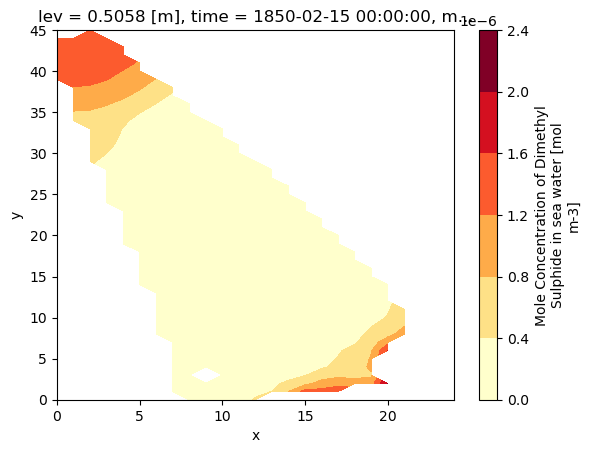

In [7]:
## Greenland
dmsset_GLarea = dset.where((dset.lon>=-10) & (dset.lon<=10) 
                           & (dset.lat <= 85)  & (dset.lat >= 60),
                         drop=True).compute()
## test plotting one time from the data array
dmsset_GLarea['dmso'].sel(time=cftime.DatetimeGregorian
                          (1850, 2, 15, 0, 0, 0, has_year_zero=False)).plot.contourf(cmap='YlOrRd')

In [8]:
dmsset_GLarea

<xarray.Dataset>
Dimensions:      (time: 1980, y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon   (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 52.85 52.1
    lat          (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev          float64 0.5058
    lev_bounds   (axis_nbounds) float64 0.0 1.024
    lon          (y, x) float64 -18.25 -17.08 -15.91 ... 49.82 50.68 51.49
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object 1850-01-01 00:00:00 ... 2015-01-...
    member_id    <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/57)
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:             CMIP
    arpege_minor_version:    6.3.2
    branch_method:           standard
    ...                      ...
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    netcdf_tracking_ids:     hdl:21.14100/75203d21-77b5-4211-b329-53b412b9c8a...
    version_id:              v20181206
    intake_esm_varname:      ['dmso']
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn

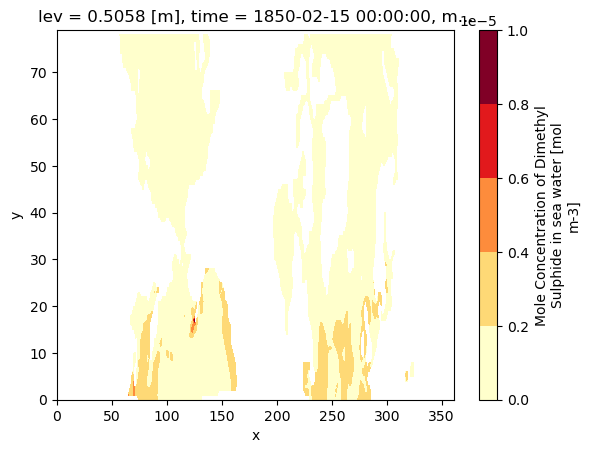

In [9]:
## Arctic
dmsset_ARCarea = dset.where((dset.lon>=-180) 
                       & (dset.lon<=180) 
                       & (dset.lat <= 90)  
                       & (dset.lat >= 45),
                         drop=True).compute()
## test plotting one time in the data array
dmsset_ARCarea['dmso'].sel(time=cftime.DatetimeGregorian
                          (1850, 2, 15, 0, 0, 0, has_year_zero=False)).plot.contourf(cmap='YlOrRd')
#dset_ARCarea['dmso']

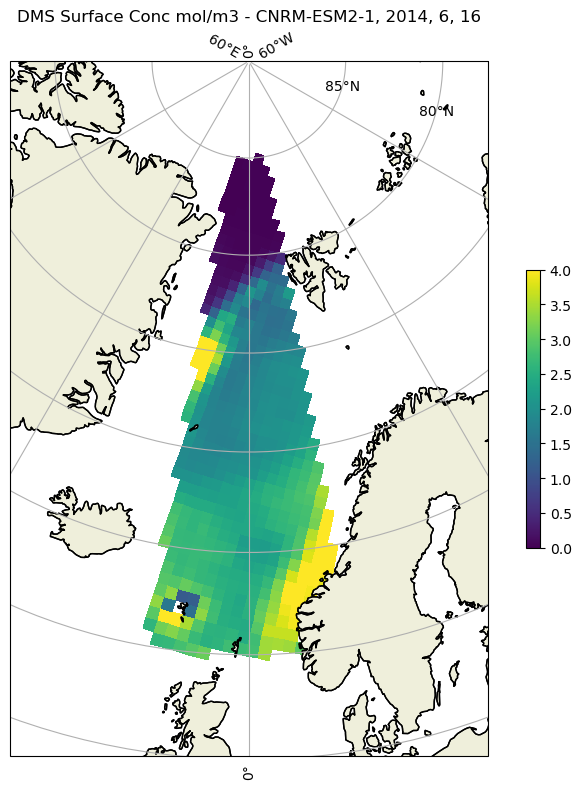

In [10]:
import cartopy
fig, ax = plt.subplots(figsize=(8,8),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-20, 20,55,90], ccrs.PlateCarree())
#pl_CMIP6


pl=ax.pcolormesh(dmsset_GLarea.lon, dmsset_GLarea.lat,
              1.0e6*dmsset_GLarea['dmso'].sel(
    time=(cftime.DatetimeGregorian(2014, 6, 16, 0, 0, 0, 0, has_year_zero=False)) ), 
    vmin=0,vmax=4,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - CNRM-ESM2-1, 2014, 6, 16')
ax.gridlines(draw_labels=True)
ax.coastlines()
fig.colorbar(pl,shrink=0.4)
fig.tight_layout()

### calculating the annual mean and its STD of DMS surface concentration for the whole historical period from 1850 to 2014

In [11]:
dms_AnnMean_AllHistrorical_GL = dmsset_GLarea.mean(dim='time').compute() #.compute does the excution of the mean operation
dms_AnnMean_AllHistrorical_GL

<xarray.Dataset>
Dimensions:     (y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat  (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon  (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 50.91 52.85 52.1
    lat         (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev         float64 0.5058
    lev_bounds  (axis_nbounds) float64 0.0 1.024
    lon         (y, x) float64 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49
    member_id   <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

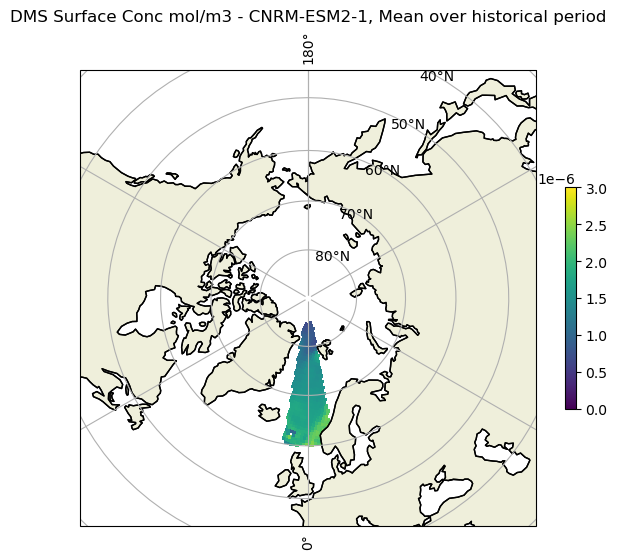

In [12]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180,45,90], ccrs.PlateCarree())



pl_CMIP6=ax.pcolormesh(dms_AnnMean_AllHistrorical_GL.lon, dms_AnnMean_AllHistrorical_GL.lat,
              dms_AnnMean_AllHistrorical_GL['dmso'], 
    vmin=0,vmax=3.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - CNRM-ESM2-1, Mean over historical period')
ax.gridlines(draw_labels=True)
ax.coastlines()
fig.colorbar(pl_CMIP6,shrink=0.4)
fig.tight_layout()

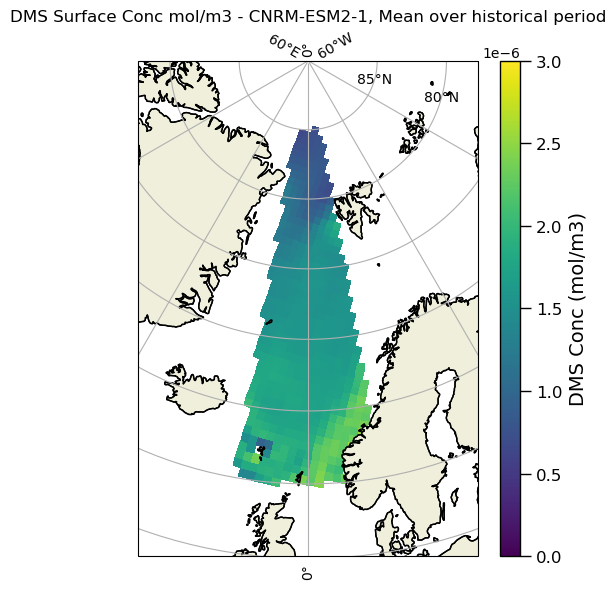

In [13]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-20, 20,55,90], ccrs.PlateCarree())



pl_CMIP6=ax.pcolormesh(dms_AnnMean_AllHistrorical_GL.lon, dms_AnnMean_AllHistrorical_GL.lat,
              dms_AnnMean_AllHistrorical_GL['dmso'], 
    vmin=0,vmax=3.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - CNRM-ESM2-1, Mean over historical period')
ax.gridlines(draw_labels=True)
ax.coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
fig.tight_layout()
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax,
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )
# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Conc (mol/m3)', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)

def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)

In [14]:
dmsset_seasonal_AnnMean_AllHistrorical_GL = dmsset_GLarea.groupby('time.season').mean('time').compute()
dmsset_seasonal_AnnMean_AllHistrorical_GL

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


<xarray.Dataset>
Dimensions:     (season: 4, y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lon  (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 50.91 52.85 52.1
    lat         (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev         float64 0.5058
    lon         (y, x) float64 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49
    member_id   <U8 'r1i1p1f2'
    bounds_lat  (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    lev_bounds  (axis_nbounds) float64 0.0 1.024
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso        (season, y, x) float32 nan nan nan nan nan ... nan nan nan nan

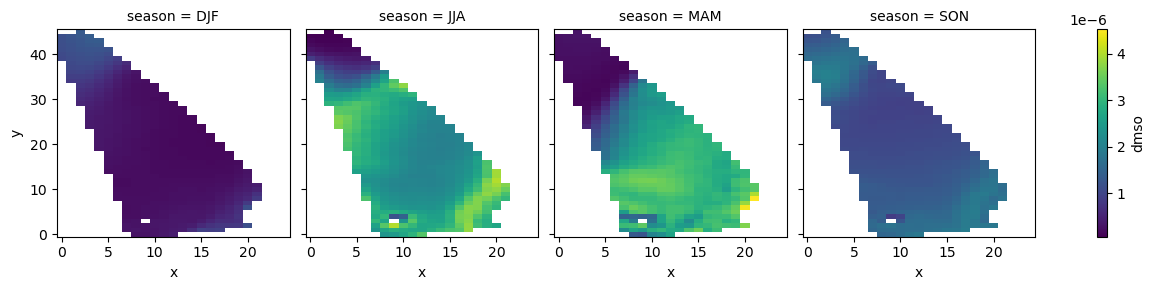

In [15]:
dmsset_seasonal_AnnMean_AllHistrorical_GL['dmso'].plot(col='season')

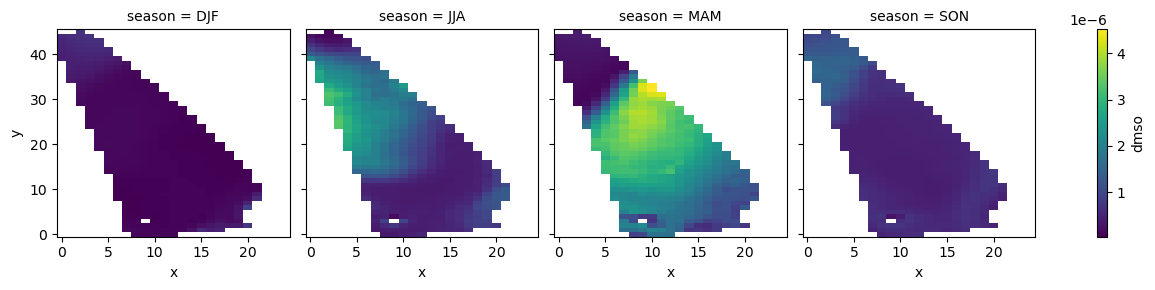

In [16]:
dmsset_seasonal_AnnSTD_AllHistrorical_GL = dmsset_GLarea.groupby('time.season').std('time').compute()
dmsset_seasonal_AnnSTD_AllHistrorical_GL
dmsset_seasonal_AnnSTD_AllHistrorical_GL['dmso'].plot(col='season')

In [17]:
## focusing on the period 2003 to 2014 that match observation  fro MODIS-Aqua
dms_2003to2014_GL = dmsset_GLarea.isel(time = slice(1836,None)).compute() #.compute does the excution of the mean operation
dms_2003to2014_GL

<xarray.Dataset>
Dimensions:      (time: 144, y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon   (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 52.85 52.1
    lat          (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev          float64 0.5058
    lev_bounds   (axis_nbounds) float64 0.0 1.024
    lon          (y, x) float64 -18.25 -17.08 -15.91 ... 49.82 50.68 51.49
  * time         (time) object 2003-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object 2003-01-01 00:00:00 ... 2015-01-...
    member_id    <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/57)
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:             CMIP
    arpege_minor_version:    6.3.2
    branch_method:           standard
    ...                      ...
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    netcdf_tracking_ids:     hdl:21.14100/75203d21-77b5-4211-b329-53b412b9c8a...
    version_id:              v20181206
    intake_esm_varname:      ['dmso']
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn

In [18]:
dms_AnnMean_2003to2014_GL = dms_2003to2014_GL.mean(dim='time').compute() 
#.compute does the excution of the mean operation
dms_AnnMean_2003to2014_GL

<xarray.Dataset>
Dimensions:     (y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat  (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon  (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 50.91 52.85 52.1
    lat         (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev         float64 0.5058
    lev_bounds  (axis_nbounds) float64 0.0 1.024
    lon         (y, x) float64 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49
    member_id   <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

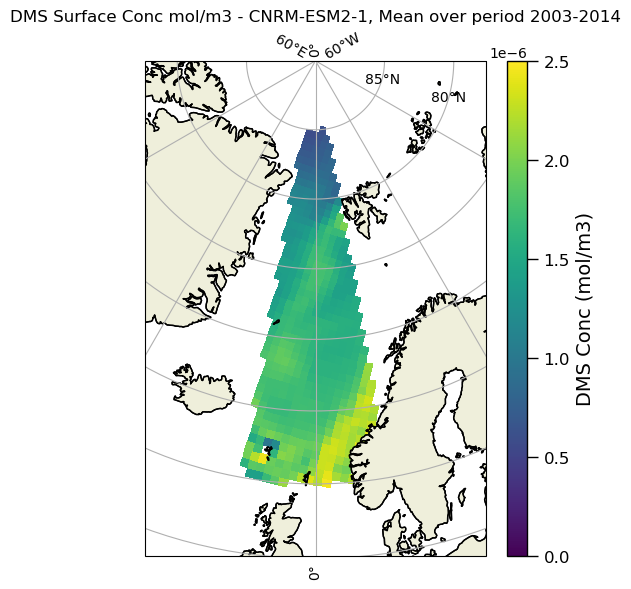

In [19]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-20, 20,55,90], ccrs.PlateCarree())



pl_CMIP6=ax.pcolormesh(dms_AnnMean_2003to2014_GL.lon, dms_AnnMean_2003to2014_GL.lat,
              dms_AnnMean_2003to2014_GL['dmso'], 
    vmin=0,vmax=2.5e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - CNRM-ESM2-1, Mean over period 2003-2014')
ax.gridlines(draw_labels=True)
ax.coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
fig.tight_layout()
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax,
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )
# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Conc (mol/m3)', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)

def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)
plt.savefig('DMS_SurfConc_CNRM-ESM-1_Greenland_Avrg2003to2014.png')

In [20]:
## checking the max
np.max(dms_AnnMean_2003to2014_GL['dmso'])


<xarray.DataArray 'dmso' ()>
array(2.45889055e-06)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'

In [21]:
## focusing on the period 2003 to 2014 that match observation from MODIS-Aqua
dms_2003to2014_ARCT = dmsset_ARCarea.isel(time = slice(1836,None)
                                         ).compute() 
#.compute does the excution of the mean operation
dms_2003to2014_ARCT

<xarray.Dataset>
Dimensions:      (time: 144, y: 80, x: 362, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 40.93 40.93 41.32 ... 50.11 50.11 49.98
    bounds_lon   (y, x, nvertex) float64 72.02 73.0 73.0 ... 73.0 72.95 73.0
    lat          (y, x) float64 41.13 41.13 41.13 41.13 ... 50.23 50.01 50.01
    lev          float64 0.5058
    lev_bounds   (axis_nbounds) float64 0.0 1.024
    lon          (y, x) float64 72.51 73.49 74.47 75.45 ... 73.04 73.0 72.99
  * time         (time) object 2003-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object 2003-01-01 00:00:00 ... 2015-01-...
    member_id    <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/57)
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:             CMIP
    arpege_minor_version:    6.3.2
    branch_method:           standard
    ...                      ...
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    netcdf_tracking_ids:     hdl:21.14100/75203d21-77b5-4211-b329-53b412b9c8a...
    version_id:              v20181206
    intake_esm_varname:      ['dmso']
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn

In [22]:
## save the data-array as netcdf file
dms_2003to2014_ARCT.to_netcdf('dms_2003to2014_ARCT.nc')

In [23]:
dms_AnnMean_2003to2014_ARCT = dms_2003to2014_ARCT.mean(dim='time').compute() 
#.compute does the excution of the mean operation
dms_AnnMean_2003to2014_ARCT

<xarray.Dataset>
Dimensions:     (y: 80, x: 362, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat  (y, x, nvertex) float64 40.93 40.93 41.32 ... 50.11 50.11 49.98
    bounds_lon  (y, x, nvertex) float64 72.02 73.0 73.0 ... 73.0 72.95 73.0
    lat         (y, x) float64 41.13 41.13 41.13 41.13 ... 50.23 50.01 50.01
    lev         float64 0.5058
    lev_bounds  (axis_nbounds) float64 0.0 1.024
    lon         (y, x) float64 72.51 73.49 74.47 75.45 ... 73.04 73.0 72.99
    member_id   <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

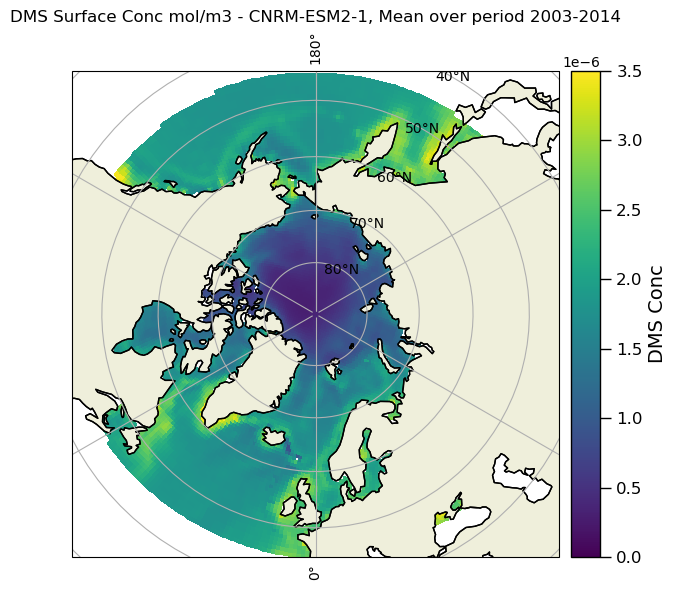

In [24]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180,45,90], ccrs.PlateCarree())

pl_CMIP6=ax.pcolormesh(dms_AnnMean_2003to2014_ARCT.lon, dms_AnnMean_2003to2014_ARCT.lat,
              dms_AnnMean_2003to2014_ARCT['dmso'],
    vmin=0,vmax=3.5e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )

ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - CNRM-ESM2-1, Mean over period 2003-2014')
ax.gridlines(draw_labels=True)
ax.coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
fig.tight_layout()
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax,
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )
# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Conc', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)

def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)

## DMS conc comparison between CNRM(model) and observation for GL
#### choose the overlapping periods. 
#### For observations, we have the DMS concentration from two satallites (Gali et al PNAS 2019, and supplementary material)
- A from MODIS-Aqua data covered the period 2003-2016 five years overlapping 2003-2007
- S from SeaWiFS data covered the period 1998-2007

In [25]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022/Antoine/Satellite_Arctic_DMS')

['escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2003_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2004_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2005_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2006_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2007_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2008_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2009_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2011_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2012_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2013_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2014_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2015_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2016_8D_28km.nc',
 'esci

In [26]:
s3files = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A*_8D_28km.nc'
remote_files = s3.glob(s3files)
fileset = [s3.open(file) for file in remote_files]
ds_obs = xr.open_mfdataset(fileset, combine='by_coords')

ds_obs

<xarray.Dataset>
Dimensions:      (year: 14, pixel: 96668, period: 46)
Coordinates:
  * year         (year) float64 2.003e+03 2.004e+03 ... 2.015e+03 2.016e+03
Dimensions without coordinates: pixel, period
Data variables:
    longitude    (year, pixel) float64 dask.array<chunksize=(1, 96668), meta=np.ndarray>
    latitude     (year, pixel) float64 dask.array<chunksize=(1, 96668), meta=np.ndarray>
    startjulday  (year, period) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    endjulday    (year, period) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    dms          (period, year, pixel) float64 dask.array<chunksize=(46, 1, 96668), meta=np.ndarray>

In [27]:
## add date
import datetime
dates = np.array([
    [datetime.datetime(int(y.values), 1, 1) + datetime.timedelta(d.values - 1) for d in ds_obs.startjulday.sel(year=y)] 
        for y in ds_obs.year])

ds_obs=ds_obs.assign_coords({ "d": (['year','period'],dates ) })
ds_obs=ds_obs.stack(time=['year','period'])
ds_obs=ds_obs.set_index(time='d')
ds_obs

<xarray.Dataset>
Dimensions:      (pixel: 96668, time: 644)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 dask.array<chunksize=(96668, 46), meta=np.ndarray>
    latitude     (pixel, time) float64 dask.array<chunksize=(96668, 46), meta=np.ndarray>
    startjulday  (time) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    endjulday    (time) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    dms          (pixel, time) float64 dask.array<chunksize=(96668, 46), meta=np.ndarray>

### choose the same area as in CNRM

In [28]:
## Greenland
DmsObs_GLarea = ds_obs.where((ds_obs.longitude>=-10) & (ds_obs.longitude<=10) 
                           & (ds_obs.latitude <= 85)  & (ds_obs.latitude >= 60),
                         drop=True).compute()
DmsObs_GLarea

<xarray.Dataset>
Dimensions:      (pixel: 2386, time: 644)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 -9.54 -9.54 -9.54 ... 8.372 8.372 8.372
    latitude     (pixel, time) float64 60.12 60.12 60.12 ... 84.88 84.88 84.88
    startjulday  (time, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (time, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (pixel, time) float64 nan nan nan nan ... nan nan nan nan

In [29]:
## we select the period from 2003 to 2014 and ignore the the last two years
dmsObs_2003to2014_GL = DmsObs_GLarea.isel(time= slice(552))
dmsObs_2003to2014_GL

<xarray.Dataset>
Dimensions:      (pixel: 2386, time: 552)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2014-12-27
    year         (time) float64 2.003e+03 2.003e+03 ... 2.014e+03 2.014e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 -9.54 -9.54 -9.54 ... 8.372 8.372 8.372
    latitude     (pixel, time) float64 60.12 60.12 60.12 ... 84.88 84.88 84.88
    startjulday  (time, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (time, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (pixel, time) float64 nan nan nan nan ... nan nan nan nan

In [30]:
dmsObs_AnnMean_2003to2014_GL = dmsObs_2003to2014_GL.mean(dim='time').compute() 
#.compute does the excution of the mean operation
dmsObs_AnnMean_2003to2014_GL


<xarray.Dataset>
Dimensions:      (pixel: 2386)
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel) float64 -9.54 -9.038 -8.536 ... 2.791 5.581 8.372
    latitude     (pixel) float64 60.12 60.12 60.12 60.12 ... 84.88 84.88 84.88
    startjulday  (pixel) float64 181.0 181.0 181.0 181.0 ... 181.0 181.0 181.0
    endjulday    (pixel) float64 187.9 187.9 187.9 187.9 ... 187.9 187.9 187.9
    dms          (pixel) float64 3.503 3.463 3.421 3.479 ... nan nan nan nan

##### Note: The coordinates system of these observations are indexed with pixels instead of (x,y) or (i,j) system. Therefore, we use this function to fix that and make the dmsos from observations comparable with CMIP6 modeling data  

In [31]:
from scipy.interpolate import griddata

def interGali(ds,var):
    '''
        Interploting data on a regular lat,lon grid
        grid is built from latitudes and the longitudes on the lowest latitude
        Input : 
            ds : xarray dataset with latitude, longitude and variable "var" to be interpolated. 
                var, lat,long must be 1d (ie. not depend on time)
            var : string name of variable
        Returns a xarray dataArray with the gridded variable and lat lon as coords
    '''
    
    # sorting according to latitudes
    lalo = pd.MultiIndex.from_arrays([ds.latitude.values, ds.longitude.values]).sortlevel(level=0)[0] 
    # get longitudes of lowest latitude
    lowlat = lalo.values[0][0]
    lon1d = np.array([x[1] for x in lalo.values if x[0]==lowlat])
    # get latitudes
    lat1d = np.unique(ds.latitude.values)
    # Building regular grid of lat and lon
    lon, lat = np.meshgrid(lon1d,lat1d)

    # interpolation
    var_gridded =griddata(
            (ds.longitude.values, ds.latitude.values), #points
            ds[var].values, #data
            (lon, lat), #grid on which to interpolate
            method='nearest')
    
    return  xr.DataArray(
        var_gridded,
        dims=("lat","lon"),
        coords={
            "lat": lat1d,
            "lon": lon1d
        }
    )
    

In [32]:
#dms_gridded_obs_test = interGali(ds_obs, 'dms')
#
dmsObs_AnnMean_2003to2014_GL = interGali(dmsObs_AnnMean_2003to2014_GL, 'dms')
dmsObs_AnnMean_2003to2014_GL

<xarray.DataArray (lat: 100, lon: 39)>
array([[3.50323675, 3.46251406, 3.42095896, ...,        nan,        nan,
               nan],
       [3.28994455, 3.37295222, 3.46074923, ...,        nan,        nan,
               nan],
       [3.22220966, 3.32487218, 3.45579508, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float64 60.12 60.38 60.62 60.88 ... 84.12 84.38 84.62 84.88
  * lon      (lon) float64 -9.54 -9.038 -8.536 -8.033 ... 8.033 8.536 9.038 9.54

In [33]:
### siberia
#lon[100,160]
#lat[70,80]

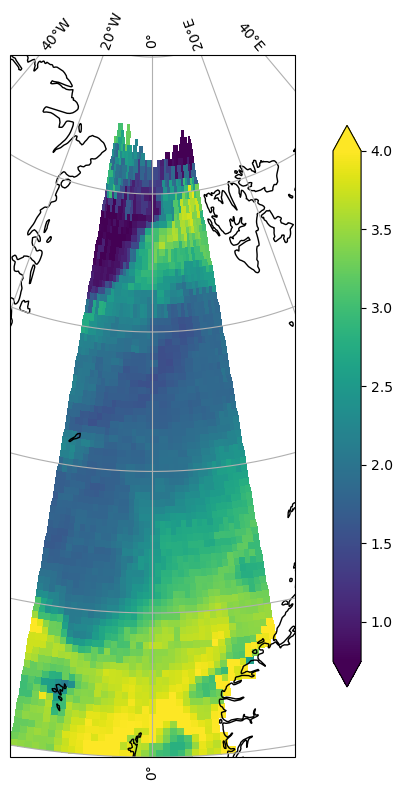

In [34]:
fig, ax = plt.subplots(figsize=(8,8),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()}
                       # subplot_kw={'projection':ccrs.PlateCarree()
                                  )

dmsObs_AnnMean_2003to2014_GL.plot.pcolormesh( 
    ax = ax,
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8},
    transform=ccrs.PlateCarree(),
    robust=True
)


ax.gridlines(draw_labels=True)
ax.coastlines()
fig.tight_layout()

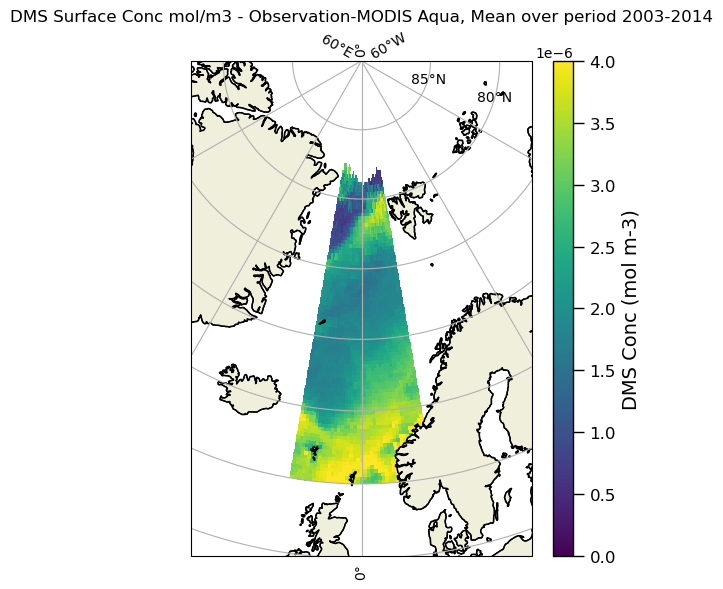

In [35]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-20, 20,55,90], ccrs.PlateCarree())

pl_CMIP6=ax.pcolormesh(dmsObs_AnnMean_2003to2014_GL.lon, dmsObs_AnnMean_2003to2014_GL.lat,
              dmsObs_AnnMean_2003to2014_GL*1.0e-6,
    vmin=0,vmax=4e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )

ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - Observation-MODIS Aqua, Mean over period 2003-2014')
ax.gridlines(draw_labels=True)
ax.coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
fig.tight_layout()
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax,
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )
# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Conc (mol m-3)', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)

def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)
plt.savefig('DMS_SurfConc_Obs_ModisAqua_Greenland_Avrg2003to2014.png')

## Global mean of ocean surface DMS concentration over GL

#### get the areacello for CNRM-ESM1-2

In [36]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(source_id=['CNRM-ESM2-1'], activity_id = ['CMIP']
                 , experiment_id=['historical'], table_id=['Ofx']
                 , variable_id=['areacello']
                 , member_id=['r1i1p1f2']
                )
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206


In [37]:
GlbArea_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [38]:
areacello = GlbArea_dict[list(GlbArea_dict.keys())[0]]
areacello = areacello.squeeze()
areacello

<xarray.Dataset>
Dimensions:     (y: 294, x: 362, nvertex: 4)
Coordinates:
    bounds_lat  (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon  (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat         (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon         (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    member_id   <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex
Data variables:
    areacello   (y, x) float32 dask.array<chunksize=(294, 362), meta=np.ndarray>
Attributes: (12/56)
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:             CMIP
    arpege_minor_version:    6.3.2
    branch_method:           standard
    ...                      ...
    xios_commit:             1442-shuffle
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/4e2f1651-782d-48b3-ba43-287dd16d7fe8
    version_id:              v20181206
    intake_esm_varname:      ['areacello']
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Ofx.gn

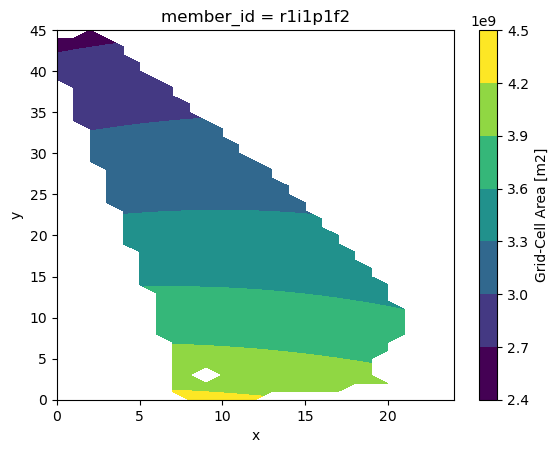

In [39]:
GLarea = areacello.areacello.where((areacello.lat>=60) 
                                   & (areacello.lat<=85) 
                                   & (areacello.lon <= 10)  
                                   & (areacello.lon >= -10),
                                  drop=True)
GLarea.plot.contourf()

In [40]:
GLarea

<xarray.DataArray 'areacello' (y: 46, x: 25)>
dask.array<where, shape=(46, 25), dtype=float32, chunksize=(46, 25), chunktype=numpy.ndarray>
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(46, 25), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(46, 25), meta=np.ndarray>
    member_id  <U8 'r1i1p1f2'
Dimensions without coordinates: y, x
Attributes:
    cell_methods:      area: sum
    description:       Cell areas for any grid used to report ocean variables...
    history:           none
    long_name:         Grid-Cell Area
    online_operation:  once
    standard_name:     cell_area
    units:             m2

In [41]:
dms_AnnMean_AllHistrorical_GL

<xarray.Dataset>
Dimensions:     (y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat  (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon  (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 50.91 52.85 52.1
    lat         (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev         float64 0.5058
    lev_bounds  (axis_nbounds) float64 0.0 1.024
    lon         (y, x) float64 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49
    member_id   <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [42]:
## averaging over the whole area of GL
dmsset_AreaMean_GL = (GLarea*dmsset_GLarea['dmso']
                               ).sum(dim=('x','y'))/GLarea.sum(dim=('x','y')
                              ,keep_attrs=True)
dmsset_AreaMean_GL

<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(1980,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f2'
    lev        float64 0.5058
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00

<xarray.DataArray (time: 165)>
dask.array<getitem, shape=(165,), dtype=float32, chunksize=(165,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f2'
    lev        float64 0.5058
  * time       (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00

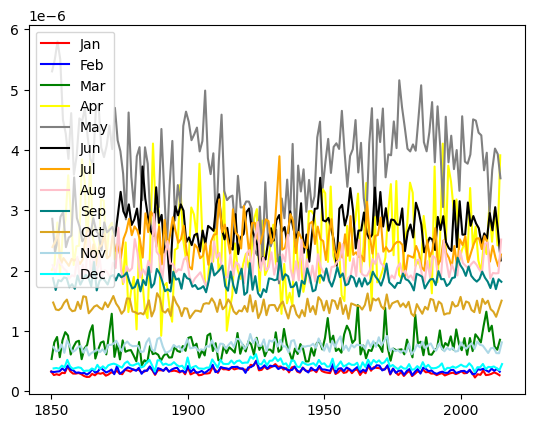

In [61]:
colors=['red','blue','green','yellow','gray','black','orange','pink','teal',
        'goldenrod','lightblue','cyan']
month_list=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i in range(0,12):
    GL_month_dmsset_AreaMean_allmonth=dmsset_AreaMean_GL[i::12]
    plt_avrg=plt.plot(GL_month_dmsset_AreaMean_allmonth.time,GL_month_dmsset_AreaMean_allmonth, 
                      color=colors[i],label=month_list[i])
plt.legend()
GL_month_dmsset_AreaMean_allmonth

<xarray.DataArray (time: 165)>
dask.array<getitem, shape=(165,), dtype=float32, chunksize=(165,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f2'
    lev        float64 0.5058
  * time       (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00

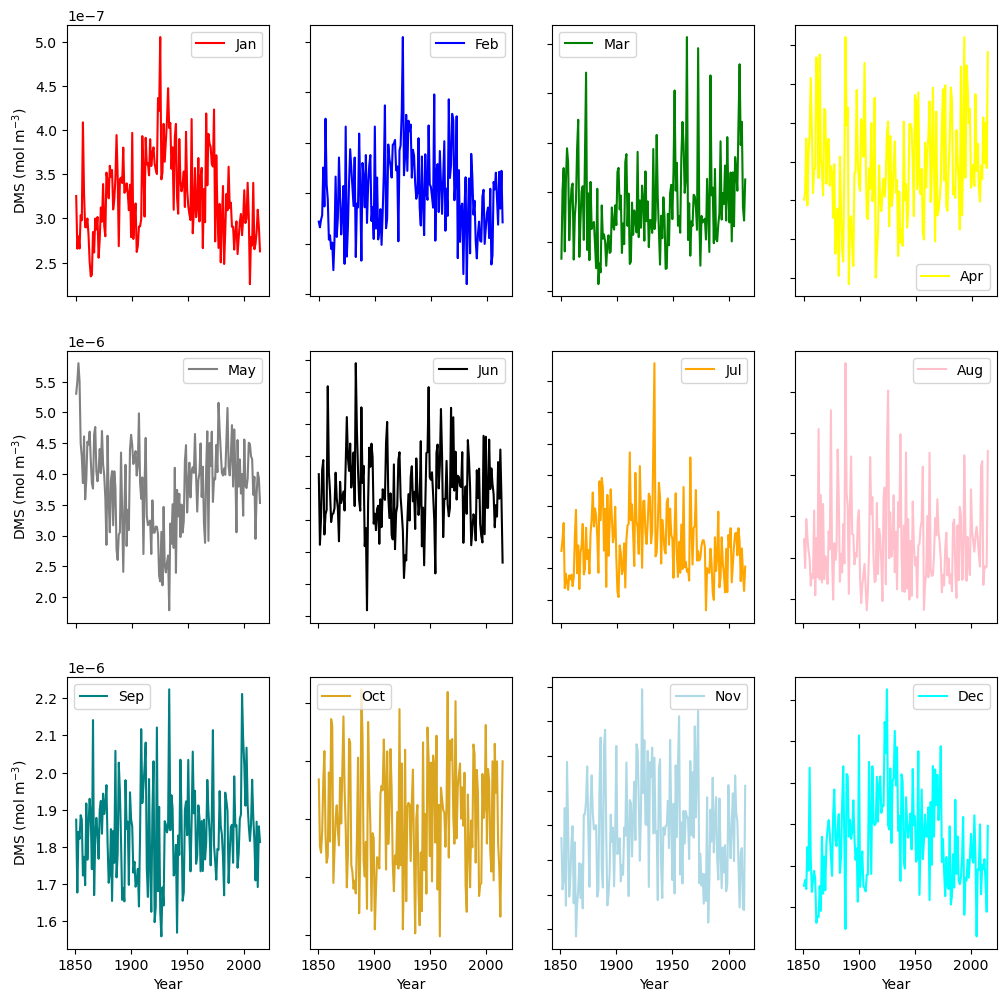

In [62]:
#xr.plot(GL_month_dmsset_AreaMean_April)
fig = plt.figure(figsize=(12,12))
for i in range (0,12):
    
    ax = plt.subplot(3,4,i+1)
    GL_month_dmsset_AreaMean_allmonth=dmsset_AreaMean_GL[i::12]
    plt_avrg=plt.plot(GL_month_dmsset_AreaMean_allmonth.time,GL_month_dmsset_AreaMean_allmonth, 
                      color=colors[i],label=month_list[i])
    if np.mod(i,4)>0:
        ax.set_yticklabels([])
    if i<=7:
        ax.set_xticklabels([])
    if i>7:
        plt.xlabel('Year')
    if np.mod(i,4)==0:
        plt.ylabel('DMS (mol m$^{-3}$)')
    plt.legend()
GL_month_dmsset_AreaMean_allmonth

In [63]:
dmsset_AreaMean_MonthAvrg_GL=dmsset_AreaMean_GL.groupby('time.month').mean().compute()
dmsset_AreaMean_MonthAvrg_GL

<xarray.DataArray (month: 12)>
array([3.2636245e-07, 3.5132348e-07, 7.5068340e-07, 2.4262367e-06,
       3.8108080e-06, 2.7195135e-06, 2.4625490e-06, 2.0747054e-06,
       1.8391564e-06, 1.3987338e-06, 7.4069203e-07, 4.3207763e-07],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [64]:
dmsset_AreaMean_MonthAvrg_STD_GL=dmsset_AreaMean_GL.groupby('time.month').std()
dmsset_AreaMean_MonthAvrg_STD_GL

<xarray.DataArray (month: 12)>
dask.array<getitem, shape=(12,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

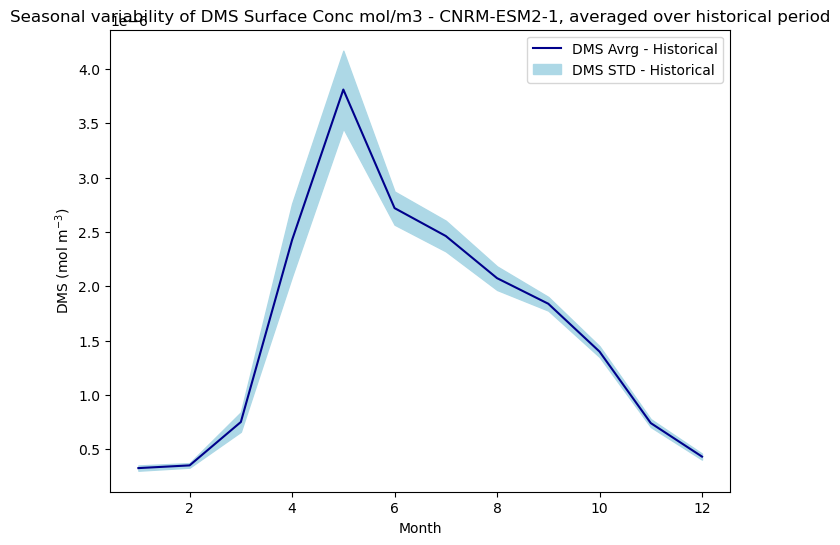

In [81]:
fig = plt.figure(figsize=(8,6))
plt_avrg=plt.plot(dmsset_AreaMean_MonthAvrg_GL.month,dmsset_AreaMean_MonthAvrg_GL, color='darkblue',
                  label='DMS Avrg - Historical'
                      )
plt.fill_between(dmsset_AreaMean_MonthAvrg_STD_GL.month,dmsset_AreaMean_MonthAvrg_GL
                 -0.5*dmsset_AreaMean_MonthAvrg_STD_GL,dmsset_AreaMean_MonthAvrg_GL
                 +0.5*dmsset_AreaMean_MonthAvrg_STD_GL,color='lightblue', label='DMS STD - Historical')
   
plt.xlabel('Month')
plt.ylabel('DMS (mol m$^{-3}$)')
plt.title('Seasonal variability of DMS Surface Conc mol/m3 - CNRM-ESM2-1, averaged over historical period')
plt.legend()


In [80]:
#dms_2003to2014_GL = dmsset_GLarea.isel(time = slice(1836,None)
#).compute() #.compute does the excution of the mean operation
dms_2003to2014_AreaMean_GL = (GLarea*dms_2003to2014_GL['dmso']
                               ).sum(dim=('x','y'))/GLarea.sum(dim=('x','y')
                              ,keep_attrs=True)
dms_2003to2014_AreaMean_GL


<xarray.DataArray (time: 144)>
dask.array<truediv, shape=(144,), dtype=float32, chunksize=(144,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f2'
    lev        float64 0.5058
  * time       (time) object 2003-01-16 12:00:00 ... 2014-12-16 12:00:00

In [77]:
dms_2003to2014_AreaMean_MonthlyMean_GL = dms_2003to2014_AreaMean_GL.groupby(
    'time.month').mean().compute()
dms_2003to2014_AreaMean_MonthlyMean_GL

<xarray.DataArray (month: 12)>
array([2.8692844e-07, 3.3930135e-07, 9.1022622e-07, 2.6846690e-06,
       3.9303745e-06, 2.6842674e-06, 2.3568157e-06, 2.1230023e-06,
       1.8380975e-06, 1.3918835e-06, 7.2163789e-07, 3.9253345e-07],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [78]:
dms_2003to2014_AreaMean_MonthlySTD_GL = dms_2003to2014_AreaMean_GL.groupby(
    'time.month').std().compute()
dms_2003to2014_AreaMean_MonthlySTD_GL

<xarray.DataArray (month: 12)>
array([3.1542474e-08, 3.0158649e-08, 1.7975526e-07, 5.3365818e-07,
       4.2256227e-07, 2.2780962e-07, 1.5513461e-07, 2.1576862e-07,
       7.6062676e-08, 9.4885287e-08, 6.6500625e-08, 3.6778008e-08],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


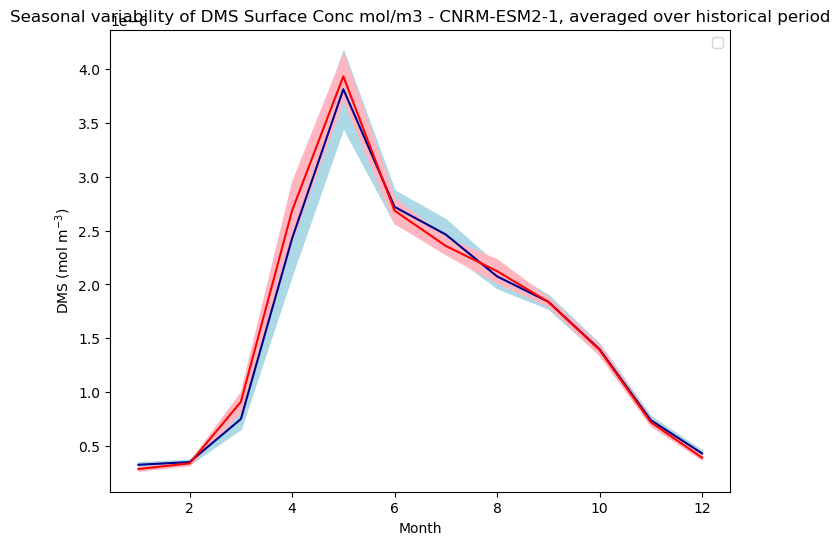

In [92]:
fig = plt.figure(figsize=(8,6))
plt_avrg=plt.plot(dmsset_AreaMean_MonthAvrg_GL.month,dmsset_AreaMean_MonthAvrg_GL, color='darkblue'
                      )
plt.plot(dms_2003to2014_AreaMean_MonthlyMean_GL.month,
         dms_2003to2014_AreaMean_MonthlyMean_GL,color='red')
plt.fill_between(dmsset_AreaMean_MonthAvrg_STD_GL.month,dmsset_AreaMean_MonthAvrg_GL
                 -0.5*dmsset_AreaMean_MonthAvrg_STD_GL,dmsset_AreaMean_MonthAvrg_GL
                 +0.5*dmsset_AreaMean_MonthAvrg_STD_GL,color='lightblue')
plt.fill_between(dms_2003to2014_AreaMean_MonthlySTD_GL.month,dms_2003to2014_AreaMean_MonthlyMean_GL
                 -0.5*dms_2003to2014_AreaMean_MonthlySTD_GL,dms_2003to2014_AreaMean_MonthlyMean_GL
                 +0.5*dms_2003to2014_AreaMean_MonthlySTD_GL,color='lightpink')
   
plt.xlabel('Month')
plt.ylabel('DMS (mol m$^{-3}$)')
plt.title('Seasonal variability of DMS Surface Conc mol/m3 - CNRM-ESM2-1, averaged over historical period')
plt.legend()



<xarray.DataArray (month: 12)>
array([2.8692844e-07, 3.3930135e-07, 9.1022622e-07, 2.6846690e-06,
       3.9303745e-06, 2.6842674e-06, 2.3568157e-06, 2.1230023e-06,
       1.8380975e-06, 1.3918835e-06, 7.2163789e-07, 3.9253345e-07],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

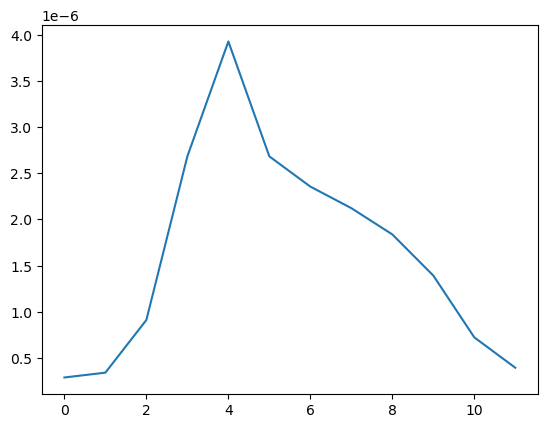

In [90]:
plt.plot(dms_2003to2014_AreaMean_MonthlyMean_GL)

dms_2003to2014_AreaMean_MonthlyMean_GL

### comparing CNRM averages with observation for the same period 2003 to 2014

<xarray.Dataset>
Dimensions:      (time: 1980, y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon   (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 52.85 52.1
    lat          (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev          float64 0.5058
    lev_bounds   (axis_nbounds) float64 0.0 1.024
    lon          (y, x) float64 -18.25 -17.08 -15.91 ... 49.82 50.68 51.49
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object 1850-01-01 00:00:00 ... 2015-01-...
    member_id    <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/57)
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:             CMIP
    arpege_minor_version:    6.3.2
    branch_method:           standard
    ...                      ...
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    netcdf_tracking_ids:     hdl:21.14100/75203d21-77b5-4211-b329-53b412b9c8a...
    version_id:              v20181206
    intake_esm_varname:      ['dmso']
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn

In [71]:
dmsObs_2003to2014_GL

<xarray.Dataset>
Dimensions:      (pixel: 2386, time: 552)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2014-12-27
    year         (time) float64 2.003e+03 2.003e+03 ... 2.014e+03 2.014e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 -9.54 -9.54 -9.54 ... 8.372 8.372 8.372
    latitude     (pixel, time) float64 60.12 60.12 60.12 ... 84.88 84.88 84.88
    startjulday  (time, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (time, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (pixel, time) float64 nan nan nan nan ... nan nan nan nan